# Introducción

**Integrantes**
* Stewart Maquera  
* Rodrigo Li      
* Jorge Quenta     

## Contexto del dataset

La criminalidad urbana representa uno de los principales desafíos para la gestión de la seguridad en ciudades metropolitanas. En este contexto, el conjunto de datos *Crimes – 2001 to Present*, publicado por el [Chicago Data Portal](https://www.chicagopolice.org/data-statistics/), constituye una fuente de información clave para comprender la evolución del crimen en la ciudad a lo largo de más de veinte años.

El dataset recopila más de **8,4 millones** de incidentes reportados desde 2001 hasta la actualidad (con la salvedad de los siete días más recientes). Incluye información sobre el tipo de delito, ubicación, arrestos, descripciones, coordenadas geográficas y división administrativa donde ocurrió cada hecho. Gracias a esta riqueza de variables, se puede realizar tanto un análisis exploratorio de datos (EDA) como la implementación de modelos de *Machine Learning* orientados a la predicción y clasificación.


## Objetivos generales y específicos

Realizar un Análisis Exploratorio de Datos (EDA) del conjunto de crímenes de Chicago (2001–actualidad), complementado con modelos de *Machine Learning*, para identificar patrones temporales, espaciales y factores asociados a los arrestos.

1. Analizar las tendencias de criminalidad en Chicago durante el periodo 2001–2025, destacando los cambios relacionados con eventos socioeconómicos relevantes.
2. Identificar los factores que influyen en la probabilidad de que un delito concluya en un arresto mediante la aplicación de modelos de clasificación supervisada.
3. ¿Dónde se concentran los delitos en Chicago y cómo han cambiado los hotspots geográficos a lo largo del tiempo?


## Preguntas iniciales de investigación

1. ¿Qué tendencias de largo plazo se observan en la frecuencia y tipo de delitos en Chicago, y cómo han influido eventos como la crisis del 2008 o la pandemia del 2020?
2. ¿Qué factores determinan la probabilidad de que un crimen resulte en un arresto, y hasta qué punto un modelo de Machine Learning puede predecir este resultado con precisión?
3. ¿Dónde se concentran los delitos en Chicago y cómo han cambiado los hotspots geográficos a lo largo del tiempo?

# Selección de datos

## Justificación del dataset elegido

El dataset seleccionado, *Crimes – 2001 to Present*, es publicado y actualizado diariamente por el Departamento de Policía de Chicago a través del portal de datos abiertos de la ciudad. Se eligió este conjunto porque:

* Posee un horizonte temporal amplio (2001–actualidad), lo que permite analizar tendencias históricas.
* Contiene variables categóricas, numéricas, espaciales y temporales que facilitan un análisis integral.
* Permite combinar técnicas de análisis descriptivo y predictivo, lo que aporta amplitud y profundidad al trabajo.

## Descripción de las variables principales

El dataset incluye **22 columnas**, entre las cuales destacan:

* **ID**: identificador único del incidente.
* **Case Number**: número de caso de la Policía de Chicago.
* **Date**: fecha y hora en que ocurrió el delito.
* **Primary Type**: categoría principal del delito (ejemplo: robo, asalto, fraude).
* **Description**: detalle secundario del delito.
* **Location Description**: lugar donde ocurrió (ejemplo: calle, residencia, comercio).
* **Arrest**: indica si el crimen resultó en arresto.
* **Domestic**: señala si estuvo vinculado a violencia doméstica.
* **District, Ward, Community Area, Beat**: divisiones administrativas y policiales.
* **Latitude, Longitude, X Coordinate, Y Coordinate**: localización aproximada.
* **Year**: año del incidente.

# Datos y preparación


In [72]:
!pip install folium
!pip install contextily


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import FeatureHasher



In [74]:
# Ruta del dataset
file_path = 'Crimes_Chicago_full.csv'

# Carga del archivo CSV con fechas
df = pd.read_csv(file_path, parse_dates=['Date'], low_memory=False)

In [75]:
# Descripción básica del dataset
total_records = df.shape[0]
total_features = df.shape[1]
print('Total de registros:', total_records)
print('Total de features:', total_features)

Total de registros: 8409498
Total de features: 22


## Manejo de datos faltantes

**Mapa de Áreas Comunitarias  y Distrito electoral (Wards) de Chicago**

<img src="imagenes/manejo_datos_faltantes.png" alt="manejo" width="500">

<img src="imagenes/types_missing_data.png" alt="tipos" width="490">


**No todos los valores faltantes son iguales**
* Faltante no al azar - Missing not at random(MNAR)
* Faltante al azar - Missing at random(MAR)
* Faltante completamente al azar - Missing completely at random (MCAR)

**Manejos**
1. Eliminacion
2. Imputacion: 
    * Datos estadisticos
    * KNN - imputation
    * Missforest - imputation
    

**Evaluacion de cantidades**

In [76]:
# Cantidad de nulos y porcentaje por columna
null_counts = df.isnull().sum()
null_percent = (null_counts / total_records) * 100
null_df = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percent})
print('\nValores nulos por columna (Tabla 1):')
print(null_df[null_df['Null Count'] > 0].sort_values(by='Null Count', ascending=False))


Valores nulos por columna (Tabla 1):
                      Null Count  Null Percentage
Ward                      614822         7.311043
Community Area            613687         7.297546
X Coordinate               93703         1.114252
Y Coordinate               93703         1.114252
Latitude                   93703         1.114252
Longitude                  93703         1.114252
Location                   93703         1.114252
Location Description       14887         0.177026
District                      47         0.000559


In [77]:
# cantidad registros y porcentaje con 1,2,3,... nulos
null_record_counts = df.isnull().sum(axis=1).value_counts().sort_index()
null_record_percent = (null_record_counts / total_records) * 100
null_record_df = pd.DataFrame({'Record Count': null_record_counts, 'Record Percentage': null_record_percent})
print('\nRegistros con n nulos (Tabla 2):')
print(null_record_df[null_record_df['Record Count'] > 0])


Registros con n nulos (Tabla 2):
   Record Count  Record Percentage
0       7699140          91.552908
1         13537           0.160973
2        603115           7.171831
3             3           0.000036
5         79132           0.940984
6          5476           0.065117
7          9094           0.108140
8             1           0.000012


Con referencia a los valores nulos por columna, se puede rescatar lo siguiente:

1. De aproximadamente **8.4 millones de registros**, el **91.55% no presenta valores nulos**, lo que indica que la calidad global del dataset es **alta**.

2. Los features relacionados con coordenadas geográficas (`X Coordinate`, `Y Coordinate`, `Latitude`, `Longitude` y `Location`) presentan alrededor de **1.11% de datos faltantes cada uno**.  
   A primera vista, eliminarlos de manera independiente sería riesgoso, ya que podría implicar una pérdida acumulada cercana al **5.57%** del dataset. Sin embargo, dado que cada columna tiene exactamente **93,703 valores nulos**, se verificara si corresponden a los **mismos registros faltantes** en todas estas variables. En caso sea así, se procedera con la **ELIMINACIÓN DIRECTA**.

3. El feature `District` es el que presenta **menos valores nulos**, con apenas **47 registros faltantes** sobre 8.4 millones. Esta cantidad es **despreciable** y puede resolverse fácilmente con **ELIMINACIÓN DIRECTA**.

4. El feature `Location Description` presenta menos del **1% de valores nulos**, siendo el segundo con menor cantidad de datos faltantes. Debido a su baja proporción, dichos valores se consideran despreciables, por lo que resulta adecuado aplicar una **ELIMINACIÓN DIRECTA**.


5. Las columnas con **mayor proporción de valores nulos** son `Ward` (7.31%) y `Community Area` (7.30%), representando el caso más crítico en términos de volumen de datos faltantes. Por lo que se evaluara un tipo de **IMPUTACIÓN**



In [78]:
# cuantos registros no tienen `X Coordinate`, `Y Coordinate`, `Latitude`, `Longitude` y `Location`
missing_coords = df[['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location']].isnull().all(axis=1)
missing_coords_count = missing_coords.sum()
print(f'\nCantidad de registros que no tienen ninguna de estos features (X Coordinate, Y Coordinate, Latitude, Longitude, Location): \n{missing_coords_count}')


Cantidad de registros que no tienen ninguna de estos features (X Coordinate, Y Coordinate, Latitude, Longitude, Location): 
93703


**Evaluando si eliminar resgistros que no tienen coordenadas**

De acuerdo al resultado lso features 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location' , son nulos en los mismos registros, por lo que no afectaria tanto perder 1.1% de los registros. Sin embargo, ello no es suficiente para proceder la eliminacion de datos, antes se debe verificar si son **MNAR,MAR,MCAR**. Para ello se procede a generar un dataframe con los datos a eliminar, para poder hacerle un analisis exhaustivo.

In [79]:
# Se crea un dataframe con los registros que tienen nulos en 'X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location'
df_sin_coords = df.dropna(subset=['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location', 'Location Description', 'District'])

missing_coords_df = df[missing_coords]
print(f'\nMuestra de registros sin coordenadas (X Coordinate, Y Coordinate, Latitude, Longitude, Location):')
missing_coords_df




Muestra de registros sin coordenadas (X Coordinate, Y Coordinate, Latitude, Longitude, Location):


,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
1,4644631,HM243132,2004-12-31 23:59:00,115XX S LAFAYETTE AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,...,34.0,53.0,06,NaN,NaN,2004,08/17/2015 03:03:40 PM,NaN,NaN,NaN
2,4606507,HM197987,2004-12-31 23:59:00,053XX N DAMEN AVE,0840,THEFT,FINANCIAL ID THEFT: OVER $300,ALLEY,False,False,...,40.0,4.0,06,NaN,NaN,2004,08/17/2015 03:03:40 PM,NaN,NaN,NaN
278,3805880,HL169683,2004-12-31 19:50:00,100XX W OHARE ST,1206,DECEPTIVE PRACTICE,"THEFT BY LESSEE,MOTOR VEH",AIRPORT/AIRCRAFT,True,False,...,41.0,76.0,11,NaN,NaN,2004,08/17/2015 03:03:40 PM,NaN,NaN,NaN
505,7076279,HR483215,2004-12-31 15:00:00,049XX S LANGLEY AVE,5002,OTHER OFFENSE,OTHER VEHICLE OFFENSE,STREET,False,True,...,4.0,38.0,26,NaN,NaN,2004,08/17/2015 03:03:40 PM,NaN,NaN,NaN
677,8955287,HW104165,2004-12-31 12:00:00,013XX W 76TH ST,0842,THEFT,AGG: FINANCIAL ID THEFT,RESIDENCE,False,False,...,17.0,71.0,06,NaN,NaN,2004,08/17/2015 03:03:40 PM,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8409490,12958667,JG122701,2005-01-01 00:00:00,007XX S KEELER AVE,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,NaN,False,False,...,24.0,26.0,11,NaN,NaN,2005,01/21/2023 03:42:35 PM,NaN,NaN,NaN
8409491,10362868,HY554697,2005-01-01 00:00:00,072XX S PEORIA ST,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,17.0,68.0,17,NaN,NaN,2005,01/02/2016 03:52:42 PM,NaN,NaN,NaN
8409494,7982771,HT214754,2005-01-01 00:00:00,072XX S EMERALD AVE,1754,OFFENSE INVOLVING CHILDREN,AGG SEX ASSLT OF CHILD FAM MBR,RESIDENCE,False,True,...,17.0,68.0,02,NaN,NaN,2005,08/17/2015 03:03:40 PM,NaN,NaN,NaN
8409496,6313296,HP402411,2005-01-01 00:00:00,087XX S HALSTED ST,0840,THEFT,FINANCIAL ID THEFT: OVER $300,RESIDENCE,False,False,...,21.0,71.0,06,NaN,NaN,2005,08/17/2015 03:03:40 PM,NaN,NaN,NaN


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_98378/895039656.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Primary Type', order=df['Primary Type'].value_counts().index, palette='viridis')


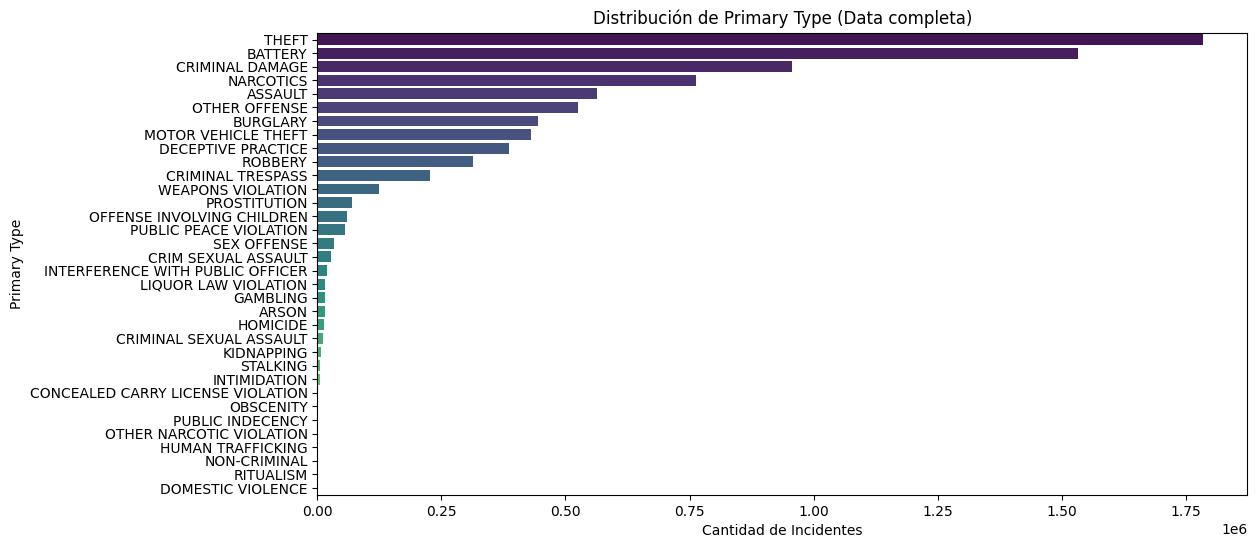

In [80]:

# bartplot de Primary Type con data completa 
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Primary Type', order=df['Primary Type'].value_counts().index, palette='viridis')
plt.title('Distribución de Primary Type (Data completa)')
plt.xlabel('Cantidad de Incidentes')
plt.ylabel('Primary Type')
plt.show()

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_98378/408527995.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=missing_coords_df, y='Primary Type', order=df['Primary Type'].value_counts().index, palette='viridis')


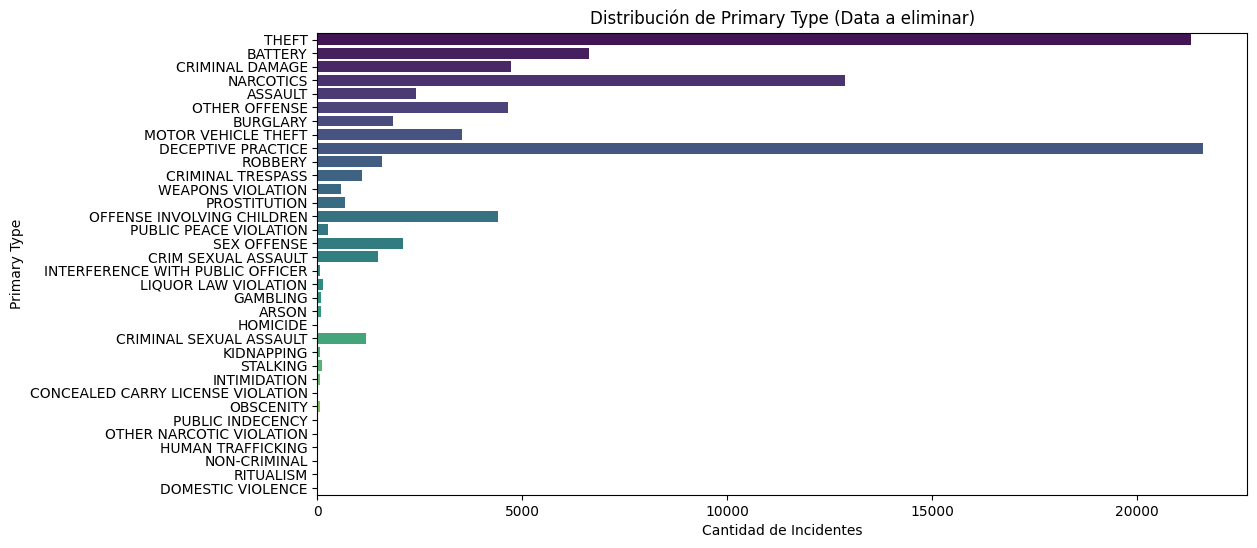

In [81]:
# bartplot de Primary Type con data con nulos en coordenadas
plt.figure(figsize=(12,6))
sns.countplot(data=missing_coords_df, y='Primary Type', order=df['Primary Type'].value_counts().index, palette='viridis')
plt.title('Distribución de Primary Type (Data a eliminar)')
plt.xlabel('Cantidad de Incidentes')
plt.ylabel('Primary Type')
plt.show()


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_98378/3445521923.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sin_coords, y='Primary Type', order=df_sin_coords['Primary Type'].value_counts().index, palette='viridis')


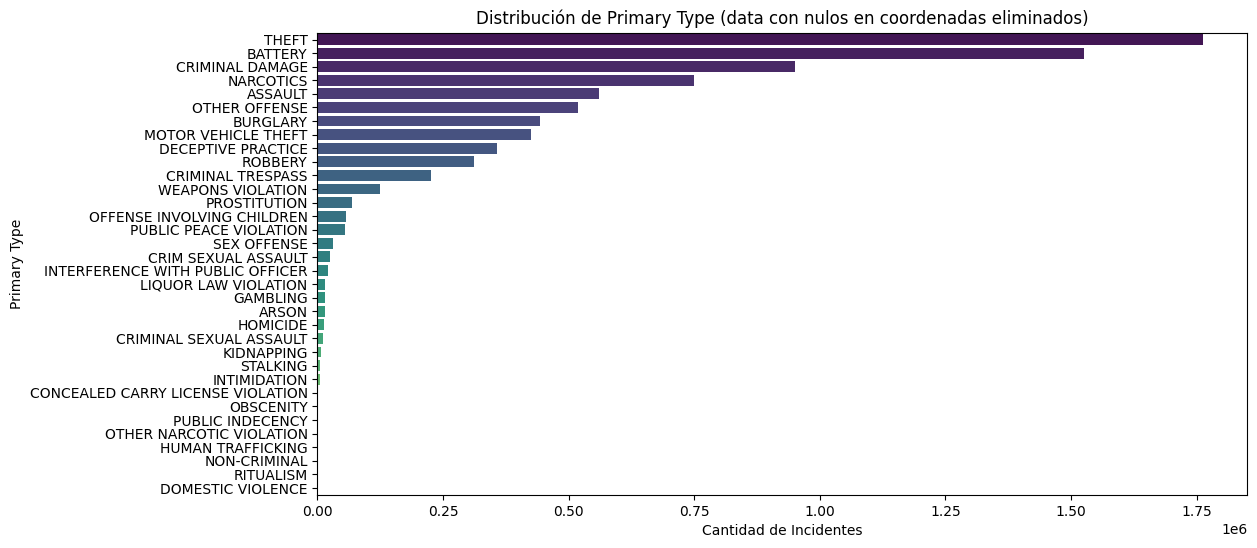

In [82]:
# bartplot de Primary Type con data sin nulos en coordenadas
plt.figure(figsize=(12,6))
sns.countplot(data=df_sin_coords, y='Primary Type', order=df_sin_coords['Primary Type'].value_counts().index, palette='viridis')
plt.title('Distribución de Primary Type (data con nulos en coordenadas eliminados)')
plt.xlabel('Cantidad de Incidentes')
plt.ylabel('Primary Type')
plt.show()

Se puede observar que, en la **Distribución de Primary Type (data completa)** frente a la **Distribución de Primary Type (data a eliminar)**, ambas mantienen en general la misma tendencia.  
Sin embargo, los valores faltantes en coordenadas no son completamente aleatorios (MCAR), ya que existe una excepción relevante: el `Primary Type` *Deceptive Practice*, que concentra una cantidad anormal de nulos.  

Aun así, al visualizar la **Distribución de Primary Type (data con nulos en coordenadas eliminados)**, se evidencia que la eliminación de estos registros no altera de manera sustancial la distribución global. La tendencia de los diferentes tipos de crimen se conserva prácticamente igual, lo que sugiere que el impacto de dicha eliminación es despreciable a nivel general.

Al igual como evaluamos el `Primary Type`, ahora prodeceremos a evaluar el `Year`, por si existe riesgo que toda la data a eliminar sean registros de un año en particular

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_98378/1818493274.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='Year', order=sorted(df['Year'].value_counts().index), palette='viridis', )


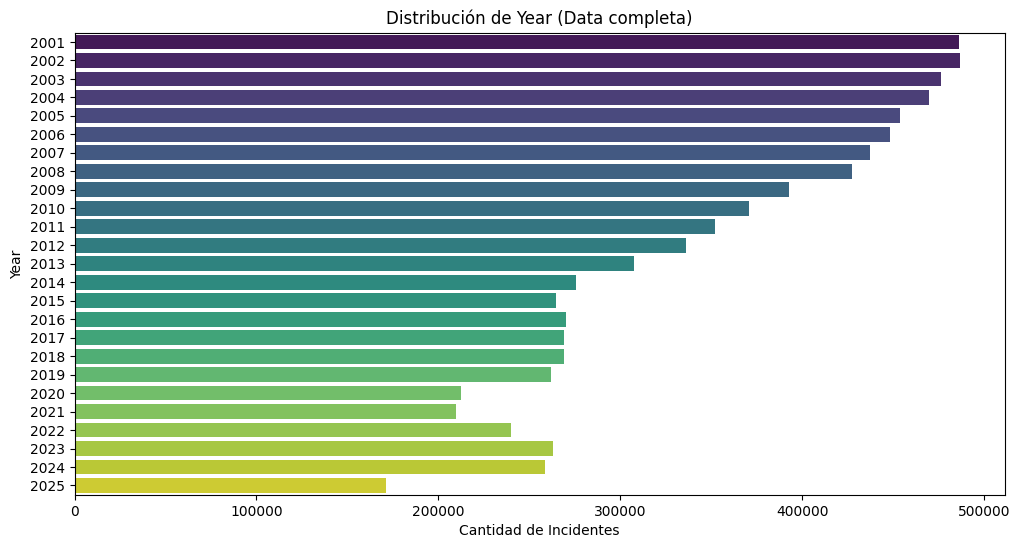

In [83]:
# bartplot de Year con data completa  años ascendente , porcentajes
plt.figure(figsize=(12,6))
sns.countplot(data=df, y='Year', order=sorted(df['Year'].value_counts().index), palette='viridis', )
plt.title('Distribución de Year (Data completa)')
plt.xlabel('Cantidad de Incidentes')
plt.ylabel('Year')
plt.show()


/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_98378/2178148821.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=missing_coords_df, y='Year', order=sorted(missing_coords_df['Year'].value_counts().index), palette='viridis')


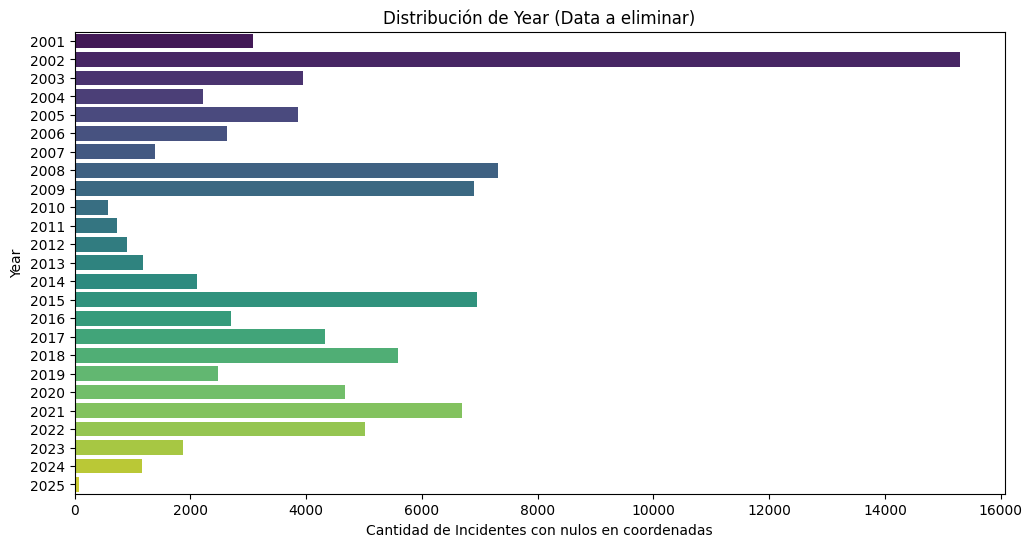

In [84]:
# bartplot Year con data con nulos en coordenadas, porcentajes
plt.figure(figsize=(12,6))
sns.countplot(data=missing_coords_df, y='Year', order=sorted(missing_coords_df['Year'].value_counts().index), palette='viridis')
plt.title('Distribución de Year (Data a eliminar)')
plt.xlabel('Cantidad de Incidentes con nulos en coordenadas')
plt.ylabel('Year')
plt.show()

/var/folders/rn/ysxq396j7lbg3qnwvfpvfsfm0000gn/T/ipykernel_98378/739185782.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_sin_coords, y='Year', order=sorted(df_sin_coords['Year'].value_counts().index), palette='viridis' )


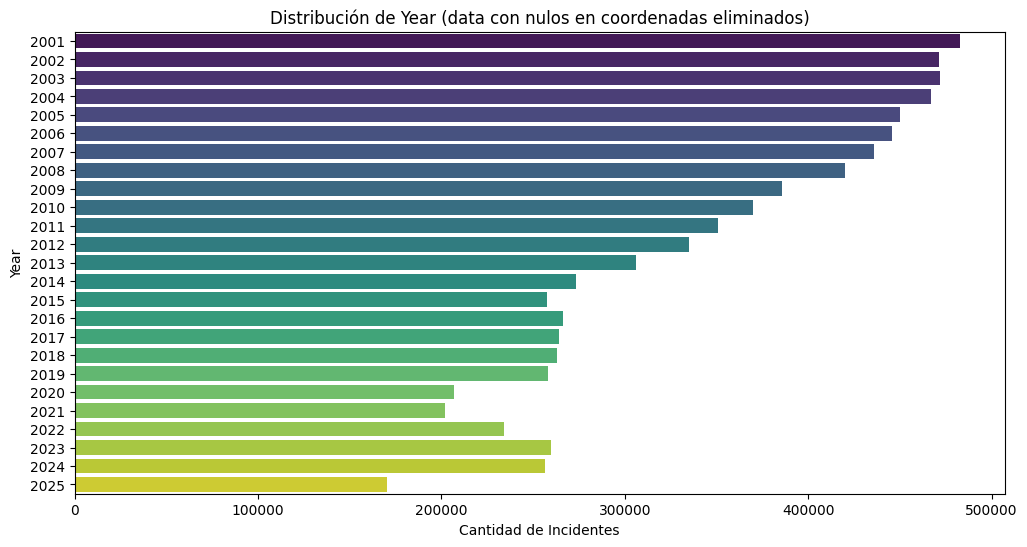

In [85]:
plt.figure(figsize=(12,6))
sns.countplot(data=df_sin_coords, y='Year', order=sorted(df_sin_coords['Year'].value_counts().index), palette='viridis' )
plt.title('Distribución de Year (data con nulos en coordenadas eliminados)')
plt.xlabel('Cantidad de Incidentes')
plt.ylabel('Year')
plt.show()


De manera similar al caso anterior, se identificó una anormalidad en el año **2002** en la **Distribución de Year(Data a eliminar)**, el cual presenta un volumen atípico de incidentes. Sin embargo, al tratarse del segundo año con mayor cantidad de registros, su impacto en la **Distribución de Year (data con nulos en coordenadas eliminados)**  no resulta significativo.  
En contraste, los demás años mantienen un comportamiento aleatorio respecto a los valores nulos.  

Por lo tanto, de acuerdo con lo evaluado (los datos faltantos en general son al azar **(MAR)**), se procede a la **eliminación directa** de los nulos en los siguientes features:  
- `X Coordinate`  
- `Y Coordinate`  
- `Latitude`  
- `Longitude`  
- `Location`  
- `Location Description`  
- `District`


In [86]:
# Eliminacion de nulos en las columnas de coordenadas, Location Description y District
df = df.dropna(subset=['X Coordinate', 'Y Coordinate', 'Latitude', 'Longitude', 'Location', 'Location Description', 'District'])

In [87]:
# Cantidad de nulos y porcentaje por columna
null_counts = df.isnull().sum()
null_percent = (null_counts / total_records) * 100
null_df = pd.DataFrame({'Null Count': null_counts, 'Null Percentage': null_percent})
print('\nValores nulos por columna (Tabla 3):')
print(null_df[null_df['Null Count'] > 0].sort_values(by='Null Count', ascending=False))


Valores nulos por columna (Tabla 3):
                Null Count  Null Percentage
Ward                605564         7.200953
Community Area      604482         7.188087


In [88]:
# cantidad registros y porcentaje con 1,2,3,... nulos
null_record_counts = df.isnull().sum(axis=1).value_counts().sort_index()
null_record_percent = (null_record_counts / total_records) * 100
null_record_df = pd.DataFrame({'Record Count': null_record_counts, 'Record Percentage': null_record_percent})
print('\nRegistros con n nulos (Tabla 4):')
print(null_record_df[null_record_df['Record Count'] > 0])


Registros con n nulos (Tabla 4):
   Record Count  Record Percentage
0       7699140          91.552908
1          3822           0.045449
2        603112           7.171796


Como podemos vusualizar, comparando la **Tabla 2** y **Tabla 4**, los registos con mas de 3 datos nulos fueron **ELIMINADOS** cuando aplicamos **eliminación directa** a las columnas de coordenadas y `District`. Por otro lado, todavia debemos evaluar que hacer son las features `Ward` (7.31%) y `Community Area` (7.30%). 

Para evaluar si es posible realizar una imputación, primero analizaremos dichas variables 

**Análisis de Ward y Community Area**

In [89]:
# Valores de los datos faltantes:
print('\nValores únicos en la columna Ward:\n', df['Ward'].unique())
print('\nValores únicos en la columna Community Area:\n', df['Community Area'].unique())



Valores únicos en la columna Ward:
 [27.  8. 34. 24. 50. 38. 42.  9. 10. 33.  6. 15. 37. 20. 35.  5. 31. 13.
 39. 30. 11. 29. 40. 21. 32. 19.  7. 14. 17. 44. 23. 18. 43. 48.  3. 16.
  2. 41. 22. 36. 26.  1. 45. 28. 12. 47. 25. 46.  4. 49. nan]

Valores únicos en la columna Community Area:
 [24. 50. 53. 29.  2. 15.  8. 49. 46. 43. 14. 69. 66. 25. 22. 19. 65. 60.
 44. 77. 73. 67.  5. 75. 63. 26. 70. 23. 47.  6.  7. 62. 16. 42. 28. 52.
  3. 71. 32. 61. 12. 20. 30. 17. 68. 51. 38. 13. 31. 39. 72. 35. 40.  1.
 10. 34. 56. 58. 33. 27. 21. 48. 41. 37. 59.  4. 64. 55. 11. 45. 57. 36.
 74. 76. 54. 18.  9. nan  0.]


**Mapa de Áreas Comunitarias  y Distrito electoral (Wards) de Chicago**

<img src="imagenes/Chicago_Community_Areas.svg.png" alt="Áreas Comunitarias de Chicago" width="300">

<img src="imagenes/Chicago-Wards.png.webp" alt="Distritos electorales de Chicago" width="300">

`Community Area` tiene valores enteros del 1 al 77, que son las 77 áreas comunitarias oficiales de la ciudad. Pero en la data aparece  un 0, que en la práctica es un valor inválido (fuera del rango oficial).
Ambas columnas tienen NaN en ~7% de los registros, y en el caso de Community Area también un 0 que debería tratarse como nulo. Por lo que se procede a unificar los nulos (NaN) y valores inválidos (0) en `Community Area`.

In [90]:
# cantidad de 0s en Community Area
count_zeros = (df['Community Area'] == 0).sum()
print(f'\nCantidad de 0s en Community Area (Antes): {count_zeros}')

# cambiar 0 por NaN en Community Area
df['Community Area'] = df['Community Area'].replace(0, np.nan)

# cantidad de 0s en Community Area
count_zeros = (df['Community Area'] == 0).sum()
print(f'\nCantidad de 0s en Community Area (Después): {count_zeros}')


Cantidad de 0s en Community Area (Antes): 69

Cantidad de 0s en Community Area (Después): 0


**Investigando mas sobre las variables**

Un *Ward* es una división política y electoral de la ciudad de Chicago, cuyos límites se modifican cada década(10 años) como parte del proceso de redistribución electoral (redistricting), lo que lo convierte en una unidad administrativa cambiante e inestable para análisis de largo plazo ([Chicago History Museum](https://www.chicagohistory.org/mapping-chicago-and-beyond-what-are-chicagos-neighborhoods-community-areas-and-wards/)). 

En contraste, las *Community Areas* son divisiones socioespaciales creadas en la década de 1930 que han permanecido estables durante casi un siglo, utilizadas ampliamente en estudios académicos, de salud pública y criminalidad por su continuidad histórica y su asociación con datos censales ([WTTW](https://www.wttw.com/chicago-by-l/sidetracks/neighborhoods-community-areas-wards-oh-my)). 

**¿Es necesario conservar ambos features? ¿Cual nos servira en función de las preguntas que establecimos?**  

Incluir tanto *Ward* como *Community Area* puede generar redundancia y colinealidad, ya que ambas ubican al registro dentro de la ciudad pero desde perspectivas distintas. Dado que el objetivo del análisis es identificar patrones sociales y espaciales más que políticos, resulta innecesario mantener los *Wards*, siendo más pertinente conservar únicamente las *Community Areas*, pues estas proveen una visión más estable y consistente del territorio urbano a lo largo del tiempo.


In [91]:
# Eliminar Columna Ward
df = df.drop(columns=['Ward'])
print('\nColumnas del DataFrame después de eliminar Ward:\n', df.columns)

# cantidad registros y porcentaje con 1,2,3,... nulos
null_record_counts = df.isnull().sum(axis=1).value_counts().sort_index()
null_record_percent = (null_record_counts / total_records) * 100
null_record_df = pd.DataFrame({'Record Count': null_record_counts, 'Record Percentage': null_record_percent})
print('\nRegistros con n nulos (Tabla 5):')
print(null_record_df[null_record_df['Record Count'] > 0])


Columnas del DataFrame después de eliminar Ward:
 Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type',
       'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat',
       'District', 'Community Area', 'FBI Code', 'X Coordinate',
       'Y Coordinate', 'Year', 'Updated On', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

Registros con n nulos (Tabla 5):
   Record Count  Record Percentage
0       7701523          91.581245
1        604551           7.188907


Community Area nulos: 604551


/Users/stewart/2025-2/DPD/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128205 (\N{ROUND PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


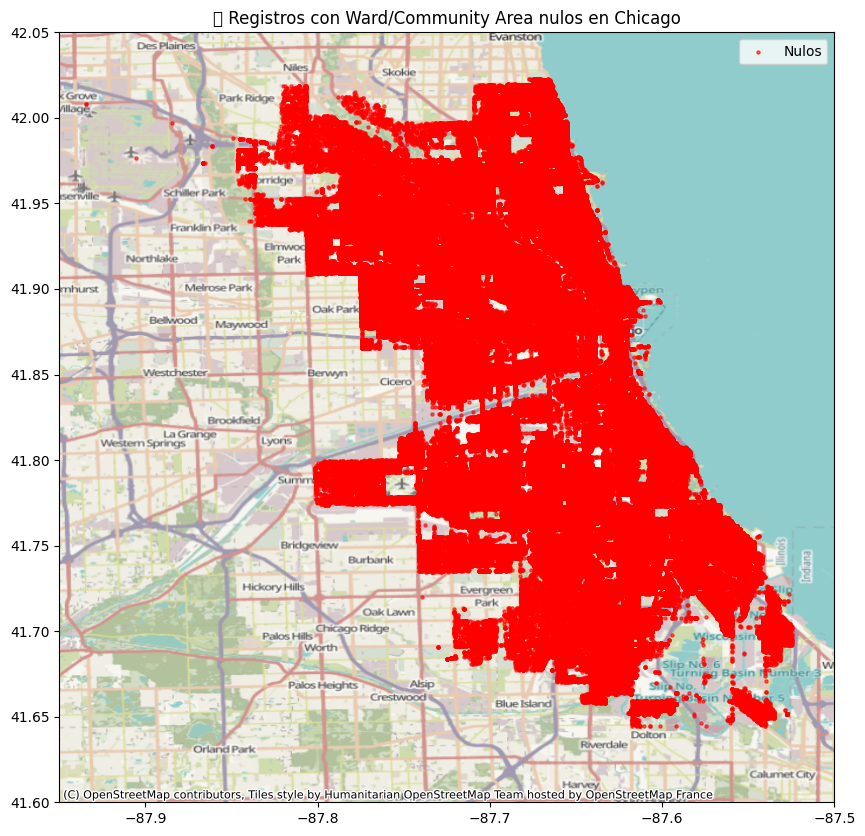

In [92]:
# Filtrar registros con Ward o Community Area nulos
missing_geo = df[df['Community Area'].isnull()]
print("Community Area nulos:", missing_geo.shape[0])


# Crear figura
fig, ax = plt.subplots(figsize=(10,10))

# Plotear puntos nulos
ax.scatter(missing_geo['Longitude'], missing_geo['Latitude'],
           c="red", s=5, alpha=0.6, label="Nulos")

# Ajustar límites al área de Chicago
ax.set_xlim(-87.95, -87.50)
ax.set_ylim(41.60, 42.05)

# Agregar mapa base de OpenStreetMap
ctx.add_basemap(ax, crs="EPSG:4326")

ax.set_title("📍 Registros con Ward/Community Area nulos en Chicago")
ax.legend()
plt.show()


En esta etapa corresponde limpiar los valores nulos de la variable `Community Area` (los cuales como se ve en el mapa estan extendidos a lo largo de todo Chicago). Para este caso, se procederá a realizar una imputación en lugar de eliminar registros. Dado que contamos con las coordenadas geográficas de todos los registros, se empleará un método de **KNN-Imputation**, el cual permitirá asignar la *Community Area* más probable en función de la proximidad espacial. Cabe destacar que los límites de las *Community Areas* han permanecido estables desde la década de 1930, por lo que esta imputación no alterará la validez de los datos ni afectará el desempeño del algoritmo.  

**Plan a seguir:**  
1. Detectar los registros con valores nulos en `Community Area`.  
2. Utilizar las coordenadas (`Latitude`, `Longitude`, `X Coordinate`, `Y Coordinate`) como referencia para identificar los vecinos más cercanos.  
3. Aplicar **KNN-Imputation** para asignar el valor de `Community Area` correspondiente.  
4. Validar los resultados verificando la coherencia espacial con los límites oficiales de las *Community Areas*.  


Antes visualizamos de manera general como se ve cada `Community Area` en el mapa, como son territorios con limites fijos, existe una separabilidad para que el modelo pueda clasificar exitosamente

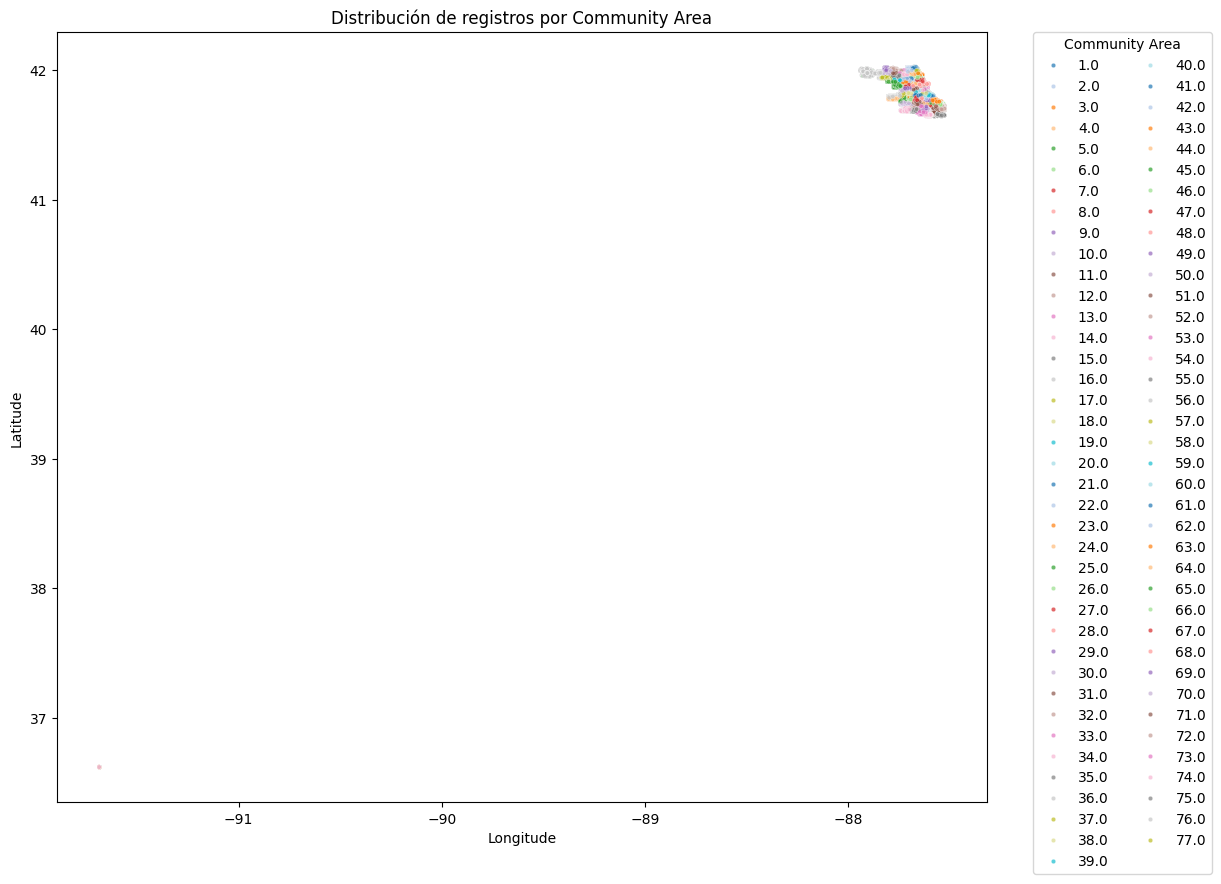

In [93]:
# Quiero ver los registros de distintos colores por community area en el mapa
sample_size = 1000000
df_sample = df.sample(n=sample_size, random_state=42)

# --- Scatter plot ---
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Community Area',
    palette='tab20',
    data=df,
    s=10,
    alpha=0.7
)

plt.title('Distribución de registros por Community Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# --- Leyenda en 2 columnas ---
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2, title='Community Area')

plt.show()

De manera accidental, vemos que existen outliers muy extremos, los cuales pueden afectar tremendamente los modelos, ya que KNN se basa en la distancia entre puntos para predecir valores o clases. Justo me di cuenta mientras estaba por aplicar el KNN para imputar los `Community Area`, y si no los controlamos, estos outliers podrían sesgar las predicciones, generando imputaciones incorrectas para registros cercanos a estos puntos atípicos. Por ello, es recomendable **identificar y filtrar los outliers extremos en las coordenadas** antes de entrenar el KNN, garantizando que la imputación sea confiable y representativa de la distribución real de la ciudad.

Por lo tanto, de pasada se evaluara los outliers de todos los features.

**Análisis de outliers**

In [94]:
#Funcion principal para detectar outliers usando el metodo del rango intercuartil
def calcular_outliers( df, columna):
    # Calcular cuartiles
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)

    # Calcular rango intercuartílico (IQR)
    IQR = Q3 - Q1

    # Calcular límites
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]
    porcentaje = len(outliers) / len(df) * 100

    # Mostrar resultados
    print(f"\nVariable: {columna}")
    print(f"Valor mínimo: {df[columna].min():.2f}")
    print(f"Valor máximo: {df[columna].max():.2f}")
    print(f"Q1 (Percentil 25): {Q1:.2f}")
    print(f"Q3 (Percentil 75): {Q3:.2f}")
    print(f"IQR: {IQR:.2f}")
    print(f"Límite inferior: {limite_inferior:.2f}")
    print(f"Límite superior: {limite_superior:.2f}")
    print(f"Outliers encontrados: {len(outliers)}")
    print(f"Porcentaje de outliers: {porcentaje:.2f}%\n")

    return outliers , porcentaje

In [95]:
for columna in df.select_dtypes(include=[np.number]).columns:
    outliers , porcentaje = calcular_outliers(df,columna)



Variable: ID
Valor mínimo: 634.00
Valor máximo: 13978553.00
Q1 (Percentil 25): 4048688.25
Q3 (Percentil 75): 10858186.75
IQR: 6809498.50
Límite inferior: -6165559.50
Límite superior: 21072434.50
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: Beat
Valor mínimo: 111.00
Valor máximo: 2535.00
Q1 (Percentil 25): 621.00
Q3 (Percentil 75): 1731.00
IQR: 1110.00
Límite inferior: -1044.00
Límite superior: 3396.00
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: District
Valor mínimo: 1.00
Valor máximo: 31.00
Q1 (Percentil 25): 6.00
Q3 (Percentil 75): 17.00
IQR: 11.00
Límite inferior: -10.50
Límite superior: 33.50
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: Community Area
Valor mínimo: 1.00
Valor máximo: 77.00
Q1 (Percentil 25): 23.00
Q3 (Percentil 75): 56.00
IQR: 33.00
Límite inferior: -26.50
Límite superior: 105.50
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: X Coordinate
Valor mínimo: 0.00
Valor máximo: 1205119.00


| Variable         | Outliers | % Outliers |
|-----------------|----------|------------|
| ID              | 0        | 0.00%      |
| Beat            | 0        | 0.00%      |
| District        | 0        | 0.00%      |
| Community Area  | 0        | 0.00%      |
| X Coordinate    | 40,217   | 0.48%      |
| Y Coordinate    | 149      | 0.00%      |
| Year            | 0        | 0.00%      |
| Latitude        | 149      | 0.00%      |
| Longitude       | 40,213   | 0.48%      |


Aunque en la mayoría de los casos el porcentaje es muy bajo. Por ejemplo, las coordenadas **X Coordinate** y **Longitude** muestran alrededor de 0.48% de registros atípicos, mientras que **Latitude** y **Y Coordinate** tienen muy pocos outliers (0.00% redondeado). Las demás variables como `Community Area`, `District`, `Year`, `Beat` y `ID` no presentan outliers significativos.

Estos outliers son importantes porque pueden **afectar negativamente el desempeño del KNN**, tanto si lo utilizo como clasificador para predecir `Community Area`, como si lo empleo como imputador para rellenar valores faltantes. Dado que KNN se basa en la distancia, los puntos extremadamente alejados podrían sesgar las predicciones de los registros cercanos, generando imputaciones incorrectas.

Por lo tanto, mi plan de acción será el siguiente:

1. **Filtrar los outliers de coordenadas** antes de aplicar cualquier modelo.  
   - Para `Latitude`, conservaré solo los valores entre 41.60, 42.05.  
   - Para `Longitude`, conservaré los valores entre -87.95, -87.50.  
   
2. **Mantener los registros limpios** para entrenar el KNN. Esto asegura que el modelo vea solo datos representativos y evite ser influenciado por valores extremos.

3. **KNeighborsClassifier** sobre el dataset filtrado. Así, la imputación de `Community Area` será confiable y no se verá perturbada por outliers.

Con este enfoque, puedo garantizar que el modelo trabajará con datos consistentes, maximizando la precisión de la imputación y evitando errores por valores atípicos.

In [96]:
# Filtrar outliers en las coordenadas geográficas 
# Definir límites razonables para las coordenadas de Chicago
lon_min, lon_max = -87.95, -87.50
lat_min, lat_max = 41.60, 42.05

# Filtrar outliers en las coordenadas geográficas
df = df[(df['Longitude'] >= lon_min) & (df['Longitude'] <= lon_max) &
        (df['Latitude'] >= lat_min) & (df['Latitude'] <= lat_max)]  

# Volver a evaluar outliers en las coordenadas
for columna in df.select_dtypes(include=[np.number]).columns:
    outliers , porcentaje = calcular_outliers(df,columna)



Variable: ID
Valor mínimo: 634.00
Valor máximo: 13978553.00
Q1 (Percentil 25): 4048688.00
Q3 (Percentil 75): 10858233.00
IQR: 6809545.00
Límite inferior: -6165629.50
Límite superior: 21072550.50
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: Beat
Valor mínimo: 111.00
Valor máximo: 2535.00
Q1 (Percentil 25): 621.00
Q3 (Percentil 75): 1731.00
IQR: 1110.00
Límite inferior: -1044.00
Límite superior: 3396.00
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: District
Valor mínimo: 1.00
Valor máximo: 31.00
Q1 (Percentil 25): 6.00
Q3 (Percentil 75): 17.00
IQR: 11.00
Límite inferior: -10.50
Límite superior: 33.50
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: Community Area
Valor mínimo: 1.00
Valor máximo: 77.00
Q1 (Percentil 25): 23.00
Q3 (Percentil 75): 56.00
IQR: 33.00
Límite inferior: -26.50
Límite superior: 105.50
Outliers encontrados: 0
Porcentaje de outliers: 0.00%


Variable: X Coordinate
Valor mínimo: 1091242.00
Valor máximo: 12051

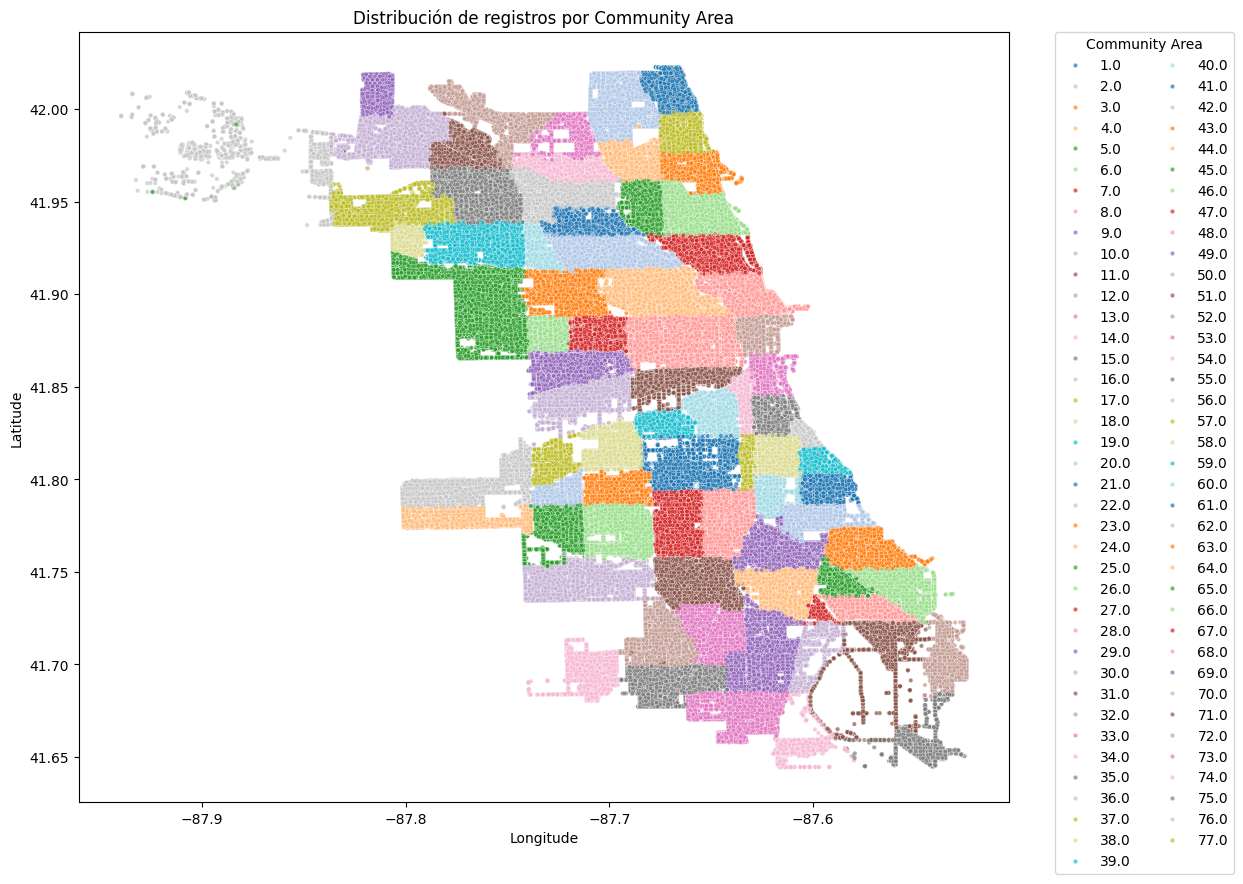

In [97]:
# Quiero ver los registros de distintos colores por community area en el mapa
sample_size = 1000000
df_sample = df.sample(n=sample_size, random_state=42)

# --- Scatter plot ---
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Community Area',
    palette='tab20',
    data=df,
    s=10,
    alpha=0.7
)

plt.title('Distribución de registros por Community Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# --- Leyenda en 2 columnas ---
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2, title='Community Area')

plt.show()

A pesar que todavia aparezcan outliers, estos se encuentran realisticamente dentro del territorio de chicago por lo tanto se quedaran ahi.

In [98]:
# === 1. Separar entrenamiento y prueba ===
train_df = df[df['Year'] <= 2020].copy()
test_df  = df[df['Year'] >= 2021].copy()

# Eliminar filas donde Community Area sea nulo
train_df = train_df.dropna(subset=["Community Area"]).copy()
test_df  = test_df.dropna(subset=["Community Area"]).copy()

# Variables que usaremos
X_train = train_df[["Latitude", "Longitude"]].values
y_train = train_df["Community Area"].astype(int).values

X_test = test_df[["Latitude", "Longitude"]].values
y_test = test_df["Community Area"].astype(int).values

# === 2. Entrenar KNN como clasificador ===
knn = KNeighborsClassifier(n_neighbors=5, weights="distance", n_jobs=-1)
knn.fit(X_train, y_train)

# === 3. Predecir en prueba ===
y_pred = knn.predict(X_test)

# === 4. Evaluar desempeño ===
acc = accuracy_score(y_test, y_pred)
f1  = f1_score(y_test, y_pred, average="weighted")

print("=== Evaluación del modelo KNN ===")
print(f"Accuracy en prueba (2021-2025): {acc:.4f}")
print(f"F1-weighted en prueba (2021-2025): {f1:.4f}")
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, digits=4))

=== Evaluación del modelo KNN ===
Accuracy en prueba (2021-2025): 0.9932
F1-weighted en prueba (2021-2025): 0.9932

--- Classification Report ---
              precision    recall  f1-score   support

           1     0.9952    0.9977    0.9964     18841
           2     0.9957    0.9942    0.9949     16815
           3     0.9935    0.9978    0.9956     18803
           4     0.9934    0.9921    0.9928      9140
           5     0.9961    0.9942    0.9952      5907
           6     0.9976    0.9939    0.9958     27627
           7     0.9863    0.9916    0.9889     17075
           8     0.9978    0.9944    0.9961     48427
           9     0.9936    0.9850    0.9893      1267
          10     0.9942    0.9940    0.9941      5704
          11     0.9897    0.9916    0.9906      4634
          12     0.9901    0.9967    0.9933      2398
          13     0.9479    0.9942    0.9705      4320
          14     0.9860    0.9724    0.9791     10634
          15     0.9877    0.9923    0.9900

Al revisar los resultados de la evaluación del modelo KNN para predecir `Community Area` en los años 2021-2025, se puede afirmar que el desempeño fue **excelente**. Obtuvimos un **accuracy de 0.9932** y un **F1-weighted de 0.9932**, lo que indica que las predicciones del modelo son altamente precisas y consistentes en todas las clases.  

Al observar el **classification report**, noto que la mayoría de las clases presentan precisiones y recalls superiores al 0.99, lo que demuestra que el modelo identifica correctamente la `Community Area` en casi todos los registros. Incluso las clases con menos registros, como la 9 y la 13, muestran métricas muy altas, lo que me da confianza en la robustez del modelo frente a desequilibrios en la frecuencia de las clases.  

Estos resultados me permiten estar seguro de que el KNN es una **herramienta confiable** para imputar los valores faltantes de `Community Area` en el dataset completo. Gracias a esta alta precisión, puedo proceder con la imputación sabiendo que los registros predichos serán correctos en la gran mayoría de los casos, preservando la integridad y la calidad de los datos.


In [99]:
# Empezar a imputar los nulos en Community Area
missing_mask = df['Community Area'].isna()
X_missing = df.loc[missing_mask, ['Latitude', 'Longitude']].values

## Predecir Community Area para los registros con nulos
imputed_areas = knn.predict(X_missing)
df.loc[missing_mask, 'Community Area'] = imputed_areas
# Verificar que ya no hay nulos en Community Area
print(f'\nCantidad de nulos en Community Area después de la imputación: {df["Community Area"].isnull().sum()}')


Cantidad de nulos en Community Area después de la imputación: 0


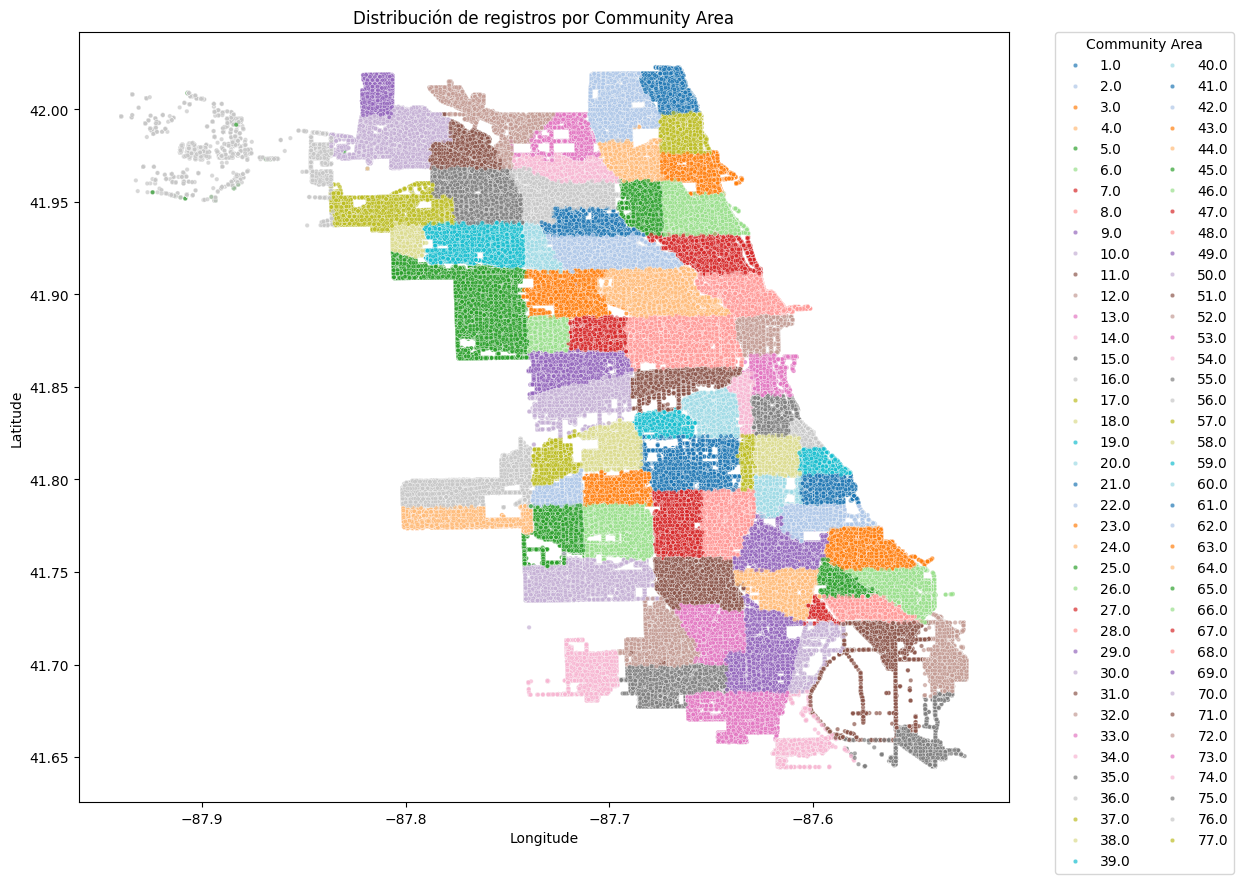

In [100]:
# Quiero ver los registros de distintos colores por community area en el mapa
sample_size = 1000000
df_sample = df.sample(n=sample_size, random_state=42)

# --- Scatter plot ---
plt.figure(figsize=(12, 10))
sns.scatterplot(
    x='Longitude',
    y='Latitude',
    hue='Community Area',
    palette='tab20',
    data=df,
    s=10,
    alpha=0.7
)

plt.title('Distribución de registros por Community Area')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# --- Leyenda en 2 columnas ---
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., ncol=2, title='Community Area')

plt.show()

**Por ultima vez verificamos la cantidad de nulos**

In [101]:
# cantidad registros y porcentaje con 1,2,3,... nulos
null_record_counts = df.isnull().sum(axis=1).value_counts().sort_index()
null_record_percent = (null_record_counts / total_records) * 100
null_record_df = pd.DataFrame({'Record Count': null_record_counts, 'Record Percentage': null_record_percent})
print('\nRegistros con n nulos (Tabla 6):')
print(null_record_df[null_record_df['Record Count'] > 0])


Registros con n nulos (Tabla 6):
   Record Count  Record Percentage
0       8305925          98.768381


Al finalizar el proceso de limpieza e imputación, podemos confirmar que **ya no existen registros con valores faltantes** en la variable `Community Area`. Gracias al uso del KNN para predecir los datos ausentes basándonos en las coordenadas, logramos mantener la integridad de la información sin perder precisión ni consistencia en las imputaciones. 

Cabe destacar que, durante este proceso, también se eliminó una columna que contenía 7% de valores nulos y la informacion no era relevante para los objetivos planteados, contribuyendo a una base de datos más limpia y manejable. A pesar de estas modificaciones, hemos logrado **conservar el 98.768381% de la data original**, lo que representa **8,305,925 registros** sobre los 8,409,496 iniciales. 

Este resultado asegura que la base de datos se encuentra lista para análisis posteriores o para alimentar modelos de machine learning, manteniendo la mayor cantidad posible de información útil y reduciendo al mínimo la pérdida de registros.


## Codificación de categóricas

El profefe solo nos mostro esto:


<img src="imagenes/codigicar_datos_categoricos.png" alt="codificar 1" width="500">

<img src="imagenes/codigo_codificar_datos_creo.png" alt="codificar 2" width="500">



Para este apartado antes de definir el metodo de codificación, se realizara un analisis superficial de las variables categoricas

* **ID**: identificador único del incidente.
* **Case Number**: número de caso de la Policía de Chicago.
* **Date**: fecha y hora en que ocurrió el delito.
* **Primary Type**: categoría principal del delito (ejemplo: robo, asalto, fraude).
* **Description**: detalle secundario del delito.
* **Location Description**: lugar donde ocurrió (ejemplo: calle, residencia, comercio).
* **Arrest**: indica si el crimen resultó en arresto.
* **Domestic**: señala si estuvo vinculado a violencia doméstica.
* **District, Ward, Community Area, Beat**: divisiones administrativas y policiales.
* **Latitude, Longitude, X Coordinate, Y Coordinate**: localización aproximada.
* **Year**: año del incidente.

In [102]:
# variables que no sean numericas
categorical_cols = df.select_dtypes(exclude=['number']).columns
print("\nVariables categóricas en el DataFrame:")
print(categorical_cols)
df.info()
df.head()


Variables categóricas en el DataFrame:
Index(['Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'FBI Code', 'Updated On',
       'Location'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 8305925 entries, 0 to 8409495
Data columns (total 21 columns):
 #   Column                Dtype         
---  ------                -----         
 0   ID                    int64         
 1   Case Number           object        
 2   Date                  datetime64[ns]
 3   Block                 object        
 4   IUCR                  object        
 5   Primary Type          object        
 6   Description           object        
 7   Location Description  object        
 8   Arrest                bool          
 9   Domestic              bool          
 10  Beat                  int64         
 11  District              float64       
 12  Community Area        float64       
 13  FBI Code          

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,District,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,3734260,HL103944,2004-12-31 23:59:00,008XX N GREENVIEW AVE,0820,THEFT,$500 AND UNDER,CHA APARTMENT,False,False,...,12.0,24.0,06,1166220.0,1905912.0,2004,02/28/2018 03:56:25 PM,41.897402,-87.664939,"(41.897401921, -87.664939363)"
3,3834225,HL205200,2004-12-31 23:59:00,009XX E 95TH ST,0810,THEFT,OVER $500,OTHER,False,False,...,5.0,50.0,06,1184179.0,1842178.0,2004,02/10/2018 03:50:01 PM,41.722108,-87.600974,"(41.722108211, -87.600973936)"
4,3744726,HL111400,2004-12-31 23:59:00,115XX S JUSTINE ST,0820,THEFT,$500 AND UNDER,STREET,False,False,...,5.0,53.0,06,1168072.0,1828211.0,2004,02/10/2018 03:50:01 PM,41.684141,-87.660371,"(41.684141387, -87.660371122)"
5,3735526,HL102499,2004-12-31 23:59:00,015XX S SPRINGFIELD AVE,0810,THEFT,OVER $500,STREET,False,False,...,10.0,29.0,06,1150631.0,1892160.0,2004,02/28/2018 03:56:25 PM,41.859984,-87.722555,"(41.859983911, -87.722555478)"
6,3732853,HL103478,2004-12-31 23:59:00,062XX N MOZART ST,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,...,24.0,2.0,07,1156207.0,1941335.0,2004,02/28/2018 03:56:25 PM,41.994813,-87.700756,"(41.99481317, -87.700755694)"


**Análisis**

Columnas que ya son numéricas o booleanas no requieren cambios

* `ID` → int64 
* `Beat` → int64
* `District` → float64 
* `Community Area` → float64 
* `Year` → int64
* `Latitude` → float64
* `Longitude` → float64
* `Arrest` → bool → ya usable
* `Domestic` → bool → ya usable




Columnas **categóricas u objetos** que se deben codificar

1. **`Case Number`**

   * Es un identificador único → **no útil para ML**, se descarta.

2. **`Date`**

   * Convertir a variables numéricas temporales:

     * `Year` (ya tienes)
     * `Month`, `Day`, `Weekday`, `Hour` para obtener patrones temporales.

3. **`Block`**

   * Texto de ubicación → opcional a **codificar** (no le veo mucho uso).

4. **`IUCR`**

   * Código del crimen → **codificar** según número de categorías.

5. **`Primary Type`**

   * Tipo de delito → **codificar** recomendado, interpretativo y útil para ML.

6. **`Description`**

   * Texto → **codificar** según número de categorías

7. **`Location Description`**

   * Tipo de lugar → **codificar**, útil para ML.

8. **`FBI Code`**

   * Código de crimen → **codificar**  según número de categorías.

9. **`Updated On`**

   * Fecha de actualización →  se descarta, no aporta valor predictivo directo.

10. **`Location`**

    * Texto con lat/lon → ya tengo `Latitude` y `Longitude`, se puede descartar.



**Resumen práctico**

| Columnas             | Acción recomendada                                |
| -------------------- | ------------------------------------------------- |
| ID                   | Eliminar para ML                                  |
| Case Number          | Eliminar para ML                                          |
| Date                 | Extraer features: Year, Month, Day, Weekday, Hour |
| Block                | Opcional       |
| IUCR                 | Codificar                           |
| Primary Type         | Codificar                                 |
| Description          | Codificar                           |
| Location Description | Codificar                                  |
| Arrest               | Mantener (bool)                                   |
| Domestic             | Mantener (bool)                                   |
| Beat                 | Mantener (numérica)                               |
| District             | Mantener (numérica)                               |
| Community Area       | Codificar                                  |
| FBI Code             | Codificar                            |
| Latitude             | Mantener                                          |
| Longitude            | Mantener                                          |
| Location             | Eliminar para ML                                            |


**Generar un df_ML listo para modelar**

In [103]:
df_ML = df.copy()


**Extraer features de Date**

In [104]:
df_ML['Year'] = df_ML['Date'].dt.year
df_ML['Month'] = df_ML['Date'].dt.month
df_ML['Day'] = df_ML['Date'].dt.day
df_ML['Weekday'] = df_ML['Date'].dt.weekday
df_ML['Hour'] = df_ML['Date'].dt.hour

**Booleanos a enteros**

In [105]:
df_ML['Arrest'] = df_ML['Arrest'].astype(int)
df_ML['Domestic'] = df_ML['Domestic'].astype(int)


**Cantidad de valores unicos**

In [106]:
#Cantidad de valores unicos por columna
unique_counts = df_ML.select_dtypes(exclude=['number']).nunique()
print("\nCantidad de valores únicos por columna:")
print(unique_counts)


Cantidad de valores únicos por columna:
Case Number             8305322
Date                    3490841
Block                     62986
IUCR                        416
Primary Type                 34
Description                 564
Location Description        218
FBI Code                     26
Updated On                 5730
Location                 908682
dtype: int64


**Tipos de valores unicos**

In [107]:
# Columnas categóricas a analizar
categorical_cols = [
    "Case Number",
    "Block",
    "IUCR",
    "Primary Type",
    "Description",
    "Location Description",
    "FBI Code"
]

# Mostrar la cantidad de valores únicos y los primeros 10 valores de cada columna
for col in categorical_cols:
    unique_values = df[col].unique()
    print(f"\nColumna: {col}")
    print(f"Número de valores únicos: {len(unique_values)}")
    print(f"Primeros 10 valores únicos: {unique_values[:10]}")



Columna: Case Number
Número de valores únicos: 8305322
Primeros 10 valores únicos: ['HL103944' 'HL205200' 'HL111400' 'HL102499' 'HL103478' 'HL100353'
 'HL100158' 'HL101304' 'HL100015' 'HL100008']

Columna: Block
Número de valores únicos: 62986
Primeros 10 valores únicos: ['008XX N GREENVIEW AVE' '009XX E 95TH ST' '115XX S JUSTINE ST'
 '015XX S SPRINGFIELD AVE' '062XX N MOZART ST' '056XX W ADDISON ST'
 '003XX E OHIO ST' '006XX E GRAND AVE' '107XX S INDIANA AVE'
 '090XX S COMMERCIAL AVE']

Columna: IUCR
Número de valores únicos: 416
Primeros 10 valores únicos: ['0820' '0810' '0910' '1305' '0486' '0870' '1477' '143A' '1320' '0460']

Columna: Primary Type
Número de valores únicos: 34
Primeros 10 valores únicos: ['THEFT' 'MOTOR VEHICLE THEFT' 'CRIMINAL DAMAGE' 'BATTERY'
 'WEAPONS VIOLATION' 'NARCOTICS' 'BURGLARY' 'ROBBERY' 'OTHER OFFENSE'
 'DECEPTIVE PRACTICE']

Columna: Description
Número de valores únicos: 564
Primeros 10 valores únicos: ['$500 AND UNDER' 'OVER $500' 'AUTOMOBILE' 'CRIMIN

Resumen de análisis:

| Columna              | Valores únicos | Recomendación               | Justificación                                                                                                    |
| -------------------- | -------------- | --------------------------- | ---------------------------------------------------------------------------------------------------------------- |
| Case Number          | 8,305,322      |  No codificar              | Es único por registro, no aporta información al modelo.                                                          |
| Block                | 62,986         |  No codificar  | Demasiadas categorías; One-Hot generaría columnas enormes y consumiría mucha memoria.                            |
| IUCR                 | 416            |  Label Encoding           | Muchos valores para One-Hot, mejor Label Encoding.                                                               |
| Primary Type         | 34             |  One-Hot                   | Pocas categorías, One-Hot es viable, sobre todo para mantener la informacion y evitar relaciones implícitas entre categorías.                                                                             |
| Description          | 564            |  Label Encoding           | Demasiadas categorías para One-Hot, Label Encoding más práctico.                                                 |
| Location Description | 218            |  Label Encoding           | Podría hacerse One-Hot por informacón, pero Label Encoding es más eficiente en memoria.                                         |
| FBI Code             | 26             |  Label Encoding                 | Pocas categorías, One-Hot, Sin embargo, con 8.3M de registros aumentar la dimensionalidad saldra caro, por ende Label coding es mejor opcion.                                                                          |
| Updated On           | 5,730          |  No codificar directamente | Se puede extraer información temporal (día, mes, año, hora) y luego codificar esas nuevas variables si se desea. |



Conclusión rápida


* **One-Hot Encoding:** `Primary Type` (pocas categorías, nominal, evita relaciones implícitas).
* **Label Encoding:** `Block`, `IUCR`, `Description`, `Location Description`, `FBI Code` (muchas categorías o dataset muy grande, evita explosión de dimensionalidad).
* **No codificar directamente:** `Case Number`, `Updated On` , `Block` (extraer información temporal si se desea).


**One-Hot Encoding**


In [108]:
# Seleccionamos las columnas para One-Hot
one_hot_cols = ["Primary Type"]

# Aplicar One-Hot Encoding
df_ML = pd.get_dummies(df_ML, columns=one_hot_cols, prefix=one_hot_cols)

# Verificar nuevas columnas
print(df_ML.columns)


Index(['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'Beat', 'District',
       'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year',
       'Updated On', 'Latitude', 'Longitude', 'Location', 'Month', 'Day',
       'Weekday', 'Hour', 'Primary Type_ARSON', 'Primary Type_ASSAULT',
       'Primary Type_BATTERY', 'Primary Type_BURGLARY',
       'Primary Type_CONCEALED CARRY LICENSE VIOLATION',
       'Primary Type_CRIM SEXUAL ASSAULT', 'Primary Type_CRIMINAL DAMAGE',
       'Primary Type_CRIMINAL SEXUAL ASSAULT',
       'Primary Type_CRIMINAL TRESPASS', 'Primary Type_DECEPTIVE PRACTICE',
       'Primary Type_DOMESTIC VIOLENCE', 'Primary Type_GAMBLING',
       'Primary Type_HOMICIDE', 'Primary Type_HUMAN TRAFFICKING',
       'Primary Type_INTERFERENCE WITH PUBLIC OFFICER',
       'Primary Type_INTIMIDATION', 'Primary Type_KIDNAPPING',
       'Primary Type_LIQUOR LAW VIOLATION', 'Primary Type_MOTOR VEHICLE TH

**Label Encoding**


In [109]:
# Columnas a codificar
label_cols = ["Block", "IUCR", "Description", "Location Description", "FBI Code"]

# Diccionario para guardar la correspondencia
label_mapping = {}

for col in label_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
    # Guardamos el mapping en el diccionario
    mapping = {i: label for i, label in enumerate(le.classes_)}
    label_mapping[col] = mapping

# Ejemplo: ver correspondencia de 'IUCR'
print("IUCR mapping:", label_mapping["IUCR"])

IUCR mapping: {0: '0110', 1: '0130', 2: '0141', 3: '0142', 4: '0261', 5: '0262', 6: '0263', 7: '0264', 8: '0265', 9: '0266', 10: '0271', 11: '0272', 12: '0273', 13: '0274', 14: '0275', 15: '0281', 16: '0291', 17: '0312', 18: '0313', 19: '031A', 20: '031B', 21: '0320', 22: '0325', 23: '0326', 24: '0330', 25: '0331', 26: '0334', 27: '0337', 28: '033A', 29: '033B', 30: '0340', 31: '041A', 32: '041B', 33: '0420', 34: '0430', 35: '0440', 36: '0450', 37: '0451', 38: '0452', 39: '0453', 40: '0454', 41: '0460', 42: '0461', 43: '0462', 44: '0470', 45: '0475', 46: '0479', 47: '0480', 48: '0481', 49: '0482', 50: '0483', 51: '0484', 52: '0485', 53: '0486', 54: '0487', 55: '0488', 56: '0489', 57: '0490', 58: '0492', 59: '0493', 60: '0494', 61: '0495', 62: '0496', 63: '0497', 64: '0498', 65: '0499', 66: '0510', 67: '051A', 68: '051B', 69: '0520', 70: '0530', 71: '0545', 72: '0550', 73: '0551', 74: '0552', 75: '0553', 76: '0554', 77: '0555', 78: '0556', 79: '0557', 80: '0558', 81: '0560', 82: '0580',

Ya he codificado las columnas categóricas que seleccioné según su número de valores únicos. Para aquellas con pocas categorías, como Primary Type, utilicé One-Hot Encoding, mientras que para las que tienen muchas categorías, como Block, IUCR, Description, Location Description y FBI Code, apliqué Label Encoding.

Para asegurarme de no perder la referencia de qué número representa cada valor original, creé un diccionario por cada columna codificada. En él, cada clave es el número asignado por el Label Encoder y el valor es la categoría original. Esto me permite revisar en cualquier momento cuál es la correspondencia, ya sea para interpretación de resultados, análisis posterior o depuración de datos. De esta forma, aunque los datos estén completamente numéricos y listos para modelos de Machine Learning, siempre puedo consultar el diccionario y saber exactamente qué representa cada código.

In [ ]:
# ejemplo de uso del diccionario
print(label_mapping["Description"][3])

ABUSE/NEGLECT: CARE FACILITY


## Escalado de numéricas

Estandarizacion o normalizacion

probablemente para (Latitude, Longitude)

## Selección de características
(correlación, varianza baja, relevancia estadística) toma ne cuenta el modelado que haremos 


<img src="imagenes/feature_selection.png" alt="Distritos electorales de Chicago" width="500">


tenemos los 3 tipos, pero segun la guia usaremos metodos de filtro y ahi tenemos estos:

las q menciono el profe:
* ganancia de informacion 
* Chi-cuadrado (para variables categóricas).
* Coeficiente de correlacion
* Variance threshold

extras
* ANOVA F-test.
* Información Mutua (Mutual Information).
* Varianza baja (descartar variables con poca variación).


**justificar la eleccion**



**Tecnicas avanzada**
* PCA
* Autoencoders

**Aplicar para el modelo si es necesario class imbalance**




**Aplicar para el modelo si es necesario class imbalance**

YA COLOQUE EN UNA TABLA ARRIBA CUALES SON IRRELEVANTES PARA MODELAR, 

# Exploración y análisis de datos

## Tendencias generales

## Pregunta 1 – Evolución a largo plazo (EDA temporal)

* Pregunta:

    ¿Qué tendencias de largo plazo se observan en la frecuencia y tipo de delitos en Chicago, y cómo han influido eventos como la crisis del 2008 o la pandemia del 2020?

* Hipótesis:

    Los delitos violentos (robos, asaltos, agresiones) muestran caídas temporales durante eventos críticos (ej. confinamientos de la pandemia), mientras que delitos como fraude o cibercrimen tienden a incrementarse en los mismos periodos.

* Justificación:

    Permite analizar los datos como una serie temporal extensa (2001–2025), conectando las fluctuaciones con eventos sociales y económicos, lo cual aporta una visión estructural del crimen en la ciudad.

## Pregunta 2 – Factores asociados a arrestos (EDA + ML supervisado)
* Pregunta:
    
    ¿Qué factores determinan la probabilidad de que un crimen resulte en un arresto, y hasta qué punto un modelo de Machine Learning puede predecir este resultado con precisión?
* Hipótesis:
    
    Los delitos domésticos y los crímenes cometidos en lugares cerrados tienen mayor probabilidad de concluir en arresto que aquellos ocurridos en la vía pública, debido a la existencia de testigos, vínculos entre víctima y agresor, y facilidad de intervención policial.
* Justificación:
    
    Es la pregunta que conecta el análisis exploratorio con Machine Learning, aplicando clasificación supervisada sobre la variable Arrest. Además, permite evaluar importancia de variables como Primary Type, Location Description, Domestic, District y variables temporales derivadas.

## Pregunta 3 – Hotspots espaciales (EDA espacial / clustering)
    
* Pregunta:

    ¿Dónde se concentran los delitos en Chicago y cómo han cambiado los hotspots geográficos a lo largo del tiempo?

* Hipótesis:

    Los hotspots delictivos presentan estabilidad en distritos centrales de la ciudad (zonas de mayor densidad y actividad económica), pero en las últimas dos décadas han surgido nuevos focos en áreas periféricas debido a procesos de urbanización y desigualdad socioeconómica.

* Justificación:

    El análisis geoespacial permite detectar patrones de concentración y desplazamiento del crimen en la ciudad. Aquí puede usarse clustering (K-Means o DBSCAN), aunque como apoyo al EDA y no como modelo principal, ya que la pregunta se responde también con mapas de calor y análisis descriptivo.

## Pregunta 4 (RELLENAR CON UNA NUEVA)

## Nuevas preguntas surgidas


# Conclusiones

**Hallazgos y limitaciones**

* Resumen de respuestas a las preguntas de investigación.
* Limitaciones del dataset (sesgos en el reporte de arrestos, cambios en la metodología).
* Restricciones técnicas del análisis (computo, muestreo).